In [271]:
import random
import gym
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

In [272]:
class ReplayBuffer:
    ''' 经验回放池 '''
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)  # 队列,先进先出

    def add(self, state, action, reward, next_state, done):  # 将数据加入buffer
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):  # 从buffer中采样数据,数量为batch_size
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):  # 目前buffer中数据的数量
        return len(self.buffer)

In [273]:
class Qnet(torch.nn.Module):
    ''' 只有一层隐藏层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
        # self.fc_a = torch.nn.Linear(hidden_dim, action_dim)
        # self.fc_s = torch.nn.Linear(hidden_dim, 1)
    def forward(self, x):
        x = F.relu(self.fc1(x))  # 隐藏层使用ReLU激活函数
        # A = self.fc_a(x)
        # V = self.fc_s(x)
        # Q = V + A - A.mean(1).view(-1, 1)
        # return Q
        return self.fc2(x)

In [274]:
class DQN:
    ''' DQN算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 epsilon, target_update, device):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim,
                          self.action_dim).to(device)  # Q网络
        # 目标网络
        self.target_q_net = Qnet(state_dim, hidden_dim,
                                 self.action_dim).to(device)
        # 使用Adam优化器
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略
        self.target_update = target_update  # 目标网络更新频率
        self.count = 0  # 计数器,记录更新次数
        self.device = device

    def take_action(self, state):  # epsilon-贪婪策略采取动作
        
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            # 返回标准的数字
            action = self.q_net(state).argmax().item()
        return action

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
       

        # print(states.shape)
        # gather函数取数，1表示从第二个维度取，按照action中的序号如t = torch.tensor([[1, 2, 3], [3, 4, 4]]) t.gather(1, torch.tensor([[1, 0],[2, 0]]))可取到[[2, 1],[4, 3]]
        q_values = self.q_net(states).gather(1, actions)  # Q值
        # 下个状态的最大Q值
        # max函数按照第一维取数，得到一个长度为2的thing，第一个是最大值列表，第二个是最大值序号，转化为列向量

        # max_action = self.q_net(next_states).max(1)[1].view(-1, 1)
        # max_next_q_values = self.target_q_net(next_states).gather(1, max_action).view(-1, 1)
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)  # TD误差目标
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # 均方误差损失函数
        
        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积,这里需要显式将梯度置为0
        dqn_loss.backward()  # 反向传播更新参数
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(
                self.q_net.state_dict())  # 更新目标网络
        self.count += 1
      

In [275]:
lr = 0.0005
num_episodes = 5000
hidden_dim = 8
gamma = 0.99
epsilon = 0.08
target_update = 250
buffer_size = 10000
minimal_size = 5000
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

# env_name = 'CartPole-v0'
# env = gym.make(env_name)
env_name = 'FrozenLake-v1'
env = gym.make(env_name, desc=None, map_name="4x4", is_slippery=True)
random.seed(0)
np.random.seed(0)
env.seed(1)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.n
# state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)


def to_16_state(state):
    state_to = np.zeros((16))
    state_to[int(state)] = 1
    return state_to


In [297]:
return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state = env.reset()
            state = to_16_state(state)
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, done, _ = env.step(action)
                next_state = to_16_state(next_state)
                replay_buffer.add(state, action, reward, next_state, done)
                state = next_state
                episode_return += reward
                # 当buffer数据的数量超过一定值后,才进行Q网络训练
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'next_states': b_ns,
                        'rewards': b_r,
                        'dones': b_d
                    }
                    agent.update(transition_dict)
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

Iteration 9: 100%|██████████| 500/500 [00:10<00:00, 47.92it/s, episode=5000, return=0.400]


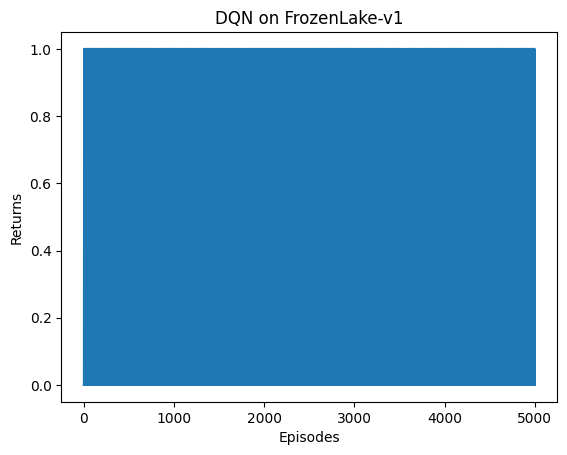

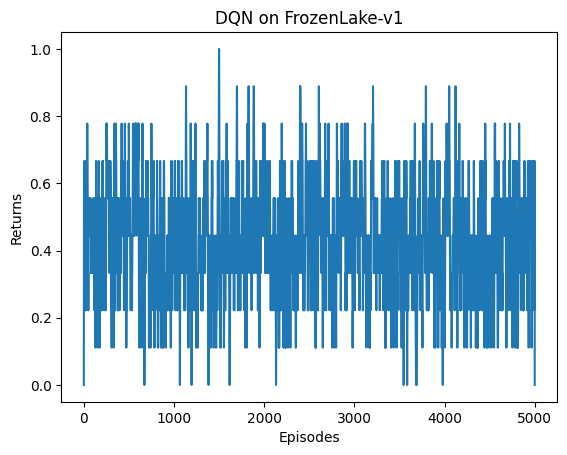

In [298]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

In [299]:
import numpy as np
import cv2

import time 
import gym
import matplotlib.pyplot as plt 
from matplotlib import animation 

def display_frames_as_gif(frames):
    
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])
   
    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=1)
    anim.save('./breakout_result.gif', writer='ffmpeg', fps=30)
    
def run_game(env):
    frames = []
    s = env.reset()
    s = to_16_state(s)
    rewards = 0
    for i_episode in range(1000):
        # frames.append(env.render(mode='rgb_array'))
        # time.sleep(0.1)
        action = agent.take_action(s)
        s_, r, done, info = env.step(action)   
        s = s_
        s = to_16_state(s)
        rewards += r
        if done:  
            break

    # env.close()
    # display_frames_as_gif(frames)
    return rewards

In [300]:

ans = []
for i in range(1000):
    env.reset()
    ans.append(run_game(env))
    # print(ans)
print("成功率：{}%".format(np.mean(ans) * 100))

成功率：44.2%
